In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import logging
import pickle

2025-12-17 20:21:14.779882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
class SMILESTokenizer:
    def __init__(self, max_length=100):
        self.max_length = max_length
        self.char_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_char = {0: '<PAD>', 1: '<UNK>'}
        self.vocab_size = 2

    def fit(self, smiles_list):
        unique_chars = set()
        for s in smiles_list:
            if isinstance(s, str):
                unique_chars.update(set(s))
        
        for char in sorted(unique_chars):
            if char not in self.char_to_idx:
                self.char_to_idx[char] = self.vocab_size
                self.idx_to_char[self.vocab_size] = char
                self.vocab_size += 1
        return self

    def encode(self, smiles):
        if not isinstance(smiles, str):
            return [0] * self.max_length
        return [self.char_to_idx.get(c, 1) for c in smiles]

    def encode_batch(self, smiles_list):
        encoded = [self.encode(s) for s in smiles_list]
        return pad_sequences(encoded, maxlen=self.max_length, padding='post', truncating='post', value=0)

In [5]:
logger.info("Loading and preprocessing data...")
df = pd.read_csv('GDSC_DATASET.csv')

if 'SMILES' not in df.columns or df['SMILES'].isnull().any():
    logger.info("SMILES column not found or has nulls, loading from smiles_cache.pkl...")
    if os.path.exists('smiles_cache.pkl'):
        with open('smiles_cache.pkl', 'rb') as f:
            smiles_map = pickle.load(f)
        df['SMILES'] = df['DRUG_NAME'].map(smiles_map)
    else:
        raise FileNotFoundError('smiles_cache.pkl not found. Please run dualtower.ipynb first.')

df = df.dropna(subset=['SMILES', 'LN_IC50'])
df = df.drop_duplicates(subset=['DRUG_NAME', 'CELL_LINE_NAME'])
logger.info(f'Dataset size after cleaning: {len(df)}')

2025-12-17 20:21:26,007 - INFO - Loading and preprocessing data...
2025-12-17 20:21:26,308 - INFO - SMILES column not found or has nulls, loading from smiles_cache.pkl...
2025-12-17 20:21:26,401 - INFO - Dataset size after cleaning: 193951


In [6]:
CELL_FEATURES = [
    'GDSC Tissue descriptor 1', 'GDSC Tissue descriptor 2', 'TCGA_DESC',
    'Microsatellite instability Status (MSI)', 'Growth Properties', 'CNA',
    'Gene Expression', 'Methylation'
]

class CellFeatureEncoder:
    def __init__(self):
        self.encoders = {col: LabelEncoder() for col in CELL_FEATURES}
        self.scaler = StandardScaler()

    def fit_transform(self, df_input):
        encoded_features = []
        for col in CELL_FEATURES:
            if col in df_input:
                col_data = df_input[col].fillna('Unknown').astype(str)
                encoded_features.append(self.encoders[col].fit_transform(col_data).reshape(-1, 1))
        if not encoded_features:
            raise ValueError('No cell features found.')
        X_cell_raw = np.hstack(encoded_features)
        return self.scaler.fit_transform(X_cell_raw)

cell_encoder = CellFeatureEncoder()
X_cell = cell_encoder.fit_transform(df)

In [7]:
smiles_tokenizer = SMILESTokenizer()
smiles_tokenizer.fit(df['SMILES'])
X_drug = smiles_tokenizer.encode_batch(df['SMILES'])
y = df['LN_IC50'].values.astype(np.float32)

In [8]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward Part
    ff_out = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    ff_out = layers.Dropout(dropout)(ff_out)
    ff_out = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(ff_out)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff_out)
    return x

def build_transformer_model(cell_input_dim, vocab_size, max_len, embed_dim=32, num_heads=4, ff_dim=64, num_transformer_blocks=1):
    # Cell Tower
    cell_input = layers.Input(shape=(cell_input_dim,), name='cell_input')
    cell_tower = layers.Dense(128, activation='relu')(cell_input)
    cell_tower = layers.BatchNormalization()(cell_tower)
    cell_tower = layers.Dropout(0.3)(cell_tower)
    cell_tower = layers.Dense(64, activation='relu')(cell_tower)

    # SMILES Transformer Tower
    smiles_input = layers.Input(shape=(max_len,), name='smiles_input')
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(smiles_input)
    
    # Add positional embedding
    positions = tf.range(start=0, limit=max_len, delta=1)
    pos_embedding = layers.Embedding(input_dim=max_len, output_dim=embed_dim)(positions)
    x += pos_embedding

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, embed_dim // num_heads, num_heads, ff_dim, dropout=0.2)
    
    drug_tower = layers.GlobalAveragePooling1D()(x)
    drug_tower = layers.Dropout(0.3)(drug_tower)
    drug_tower = layers.Dense(64, activation='relu')(drug_tower)

    # Fusion
    concat = layers.Concatenate()([cell_tower, drug_tower])
    out = layers.Dense(128, activation='relu')(concat)
    out = layers.Dropout(0.3)(out)
    out = layers.Dense(1)(out)
    
    model = keras.Model(inputs=[cell_input, smiles_input], outputs=out, name='DrugSensitivityTransformer')
    return model

2025-12-17 20:28:32,651 - INFO - Splitting data and building model...


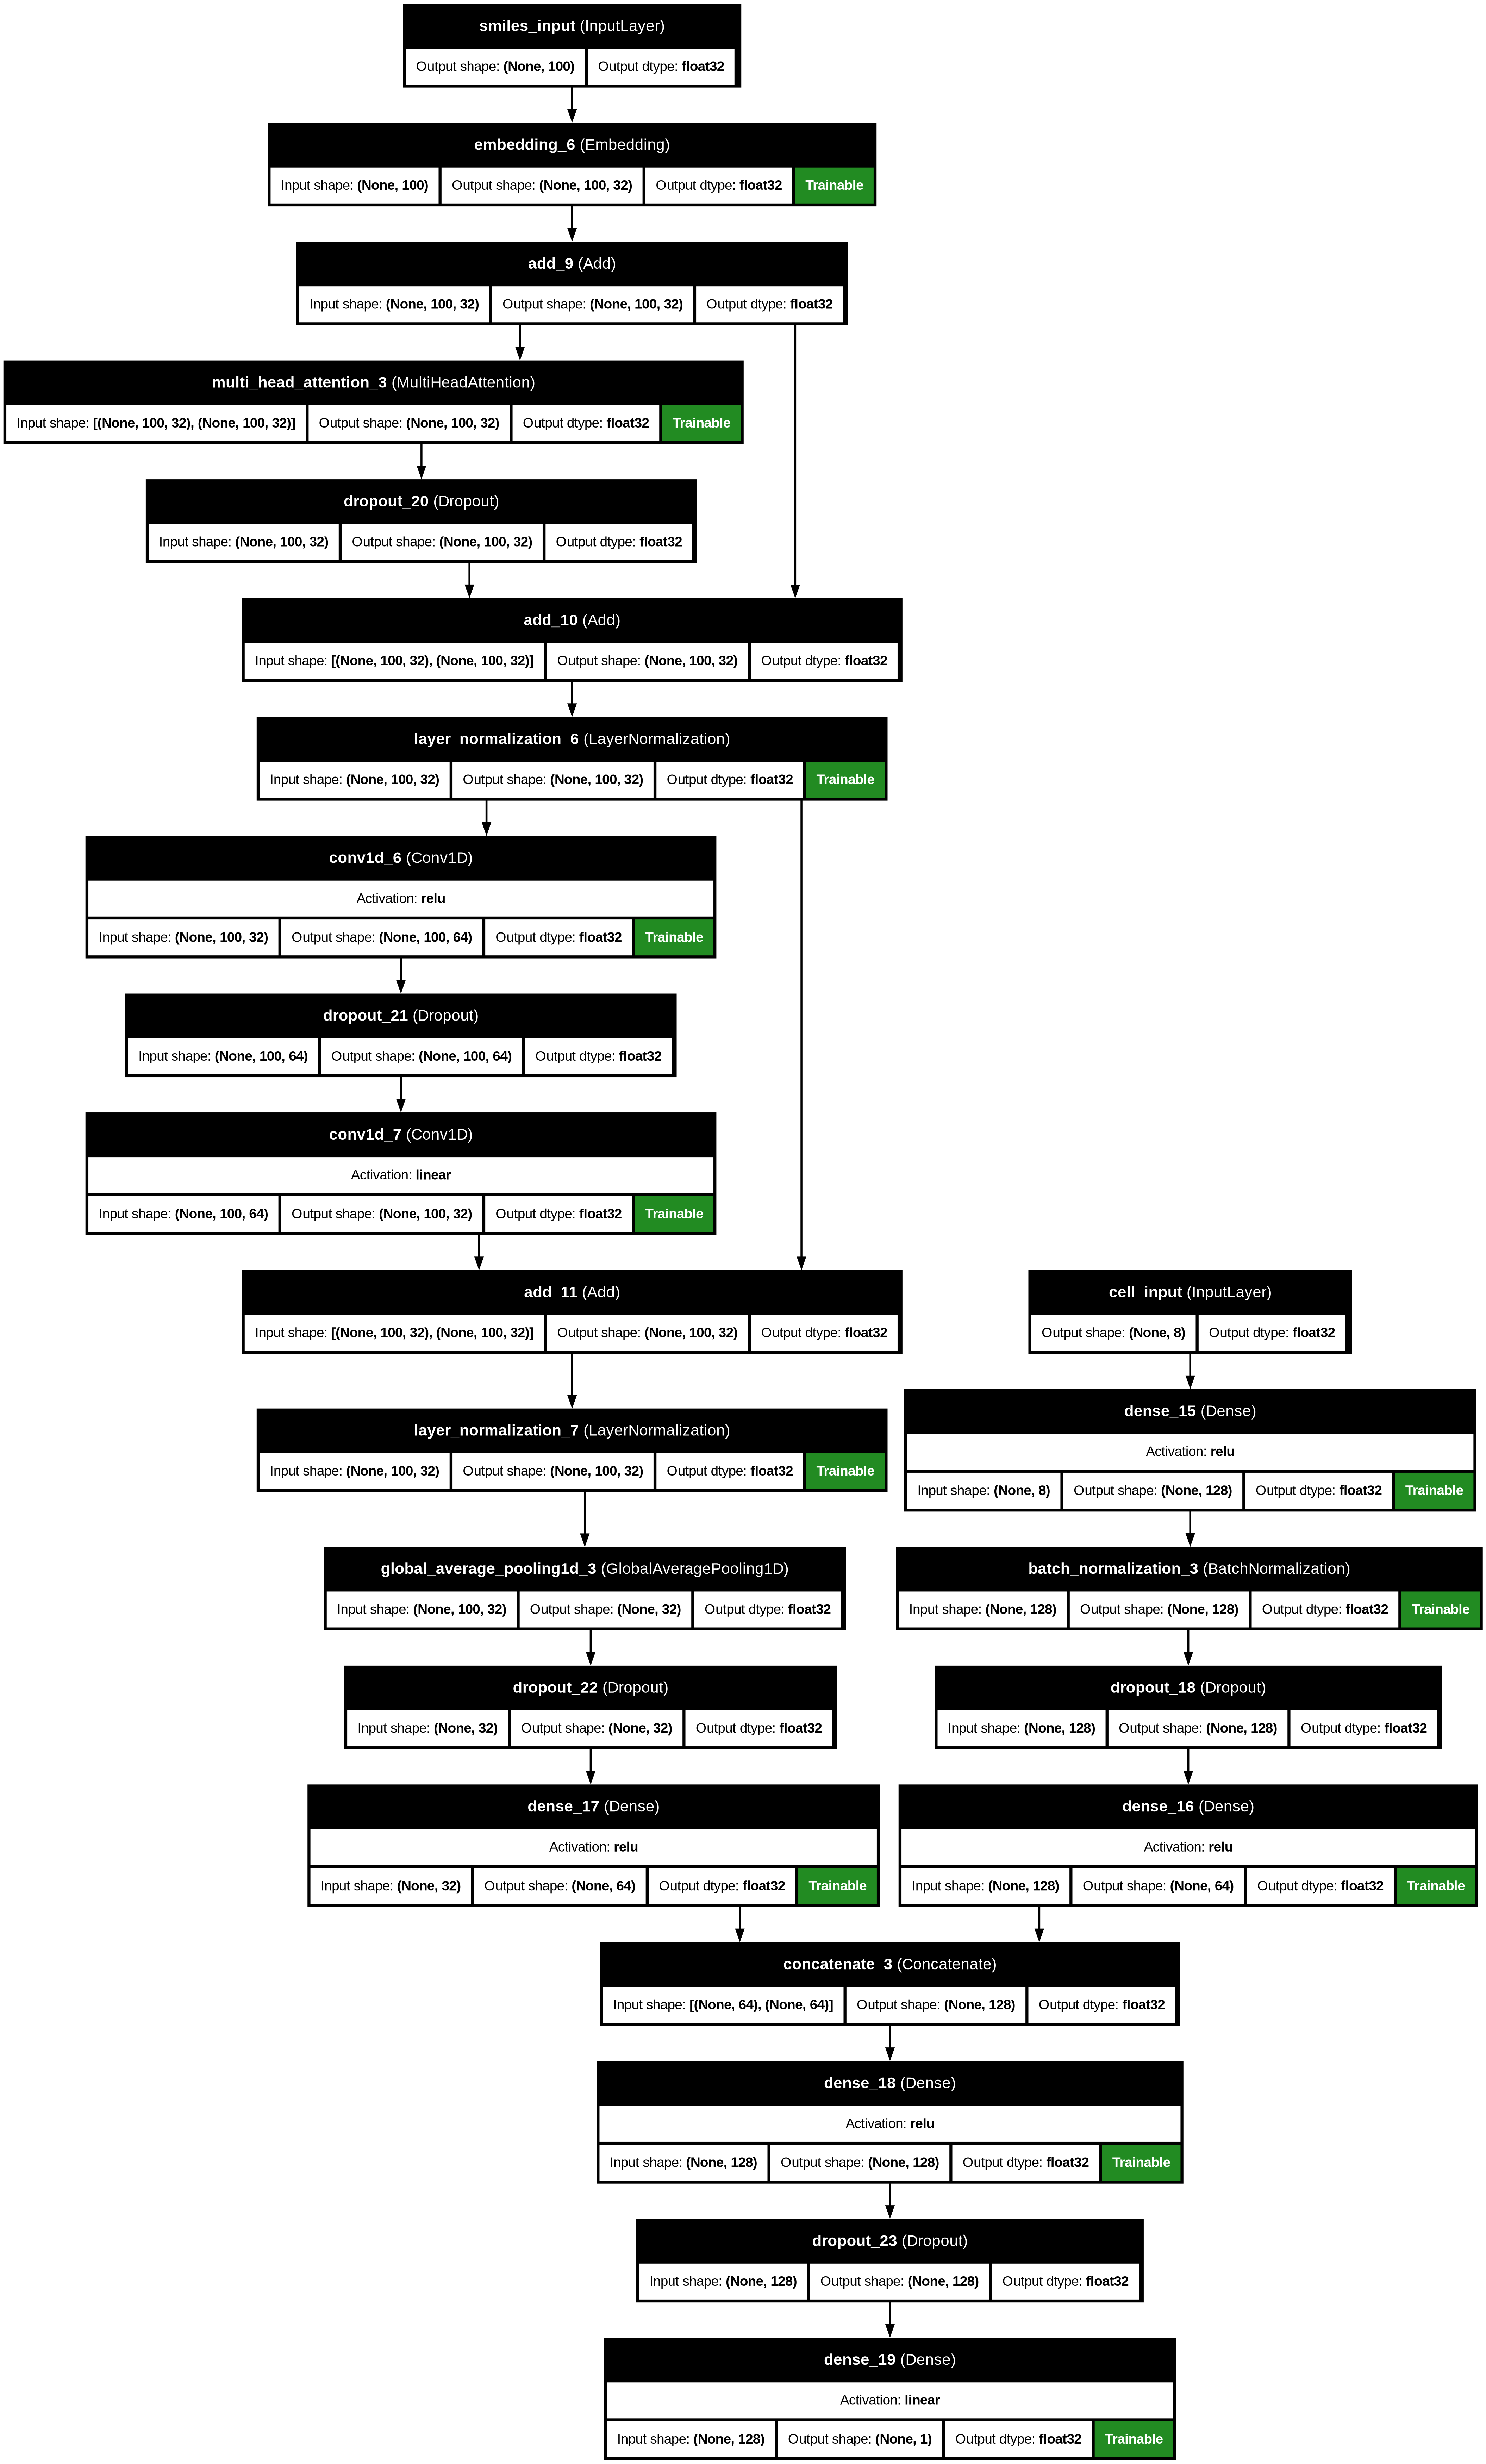

In [12]:
logger.info("Splitting data and building model...")
X_cell_train, X_cell_val, X_drug_train, X_drug_val, y_train, y_val = train_test_split(
    X_cell, X_drug, y, test_size=0.2, random_state=42
)

model = build_transformer_model(
    cell_input_dim=X_cell.shape[1],
    vocab_size=smiles_tokenizer.vocab_size,
    max_len=smiles_tokenizer.max_length
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)
#model.summary()

keras.utils.plot_model(
    model,
    to_file='transformer_model.png',
    show_shapes=True,
    show_dtype=True,              # Shows the data type (e.g., float32)
    show_layer_names=True,        # Ensures layer names are visible
    rankdir='TB',                 # 'TB' for Top-Bottom or 'LR' for Left-Right
    expand_nested=True,           # Expands nested models into clusters
    dpi=200,                      # Higher resolution for clearer text
    show_layer_activations=True,  # Shows activations (e.g., relu, softmax)
    show_trainable=True           # Indicates if a layer is trainable
)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=5)
]

logger.info("Starting model training...")
history = model.fit(
    [X_cell_train, X_drug_train], y_train,
    validation_data=([X_cell_val, X_drug_val], y_val),
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

logger.info("Evaluating model...")
y_pred = model.predict([X_cell_val, X_drug_val]).flatten()
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
logger.info(f'Test MSE: {mse:.4f}')
logger.info(f'Test R2: {r2:.4f}')

NameError: name 'logger' is not defined

2025-12-14 17:01:51,168 - INFO - Plotting results...


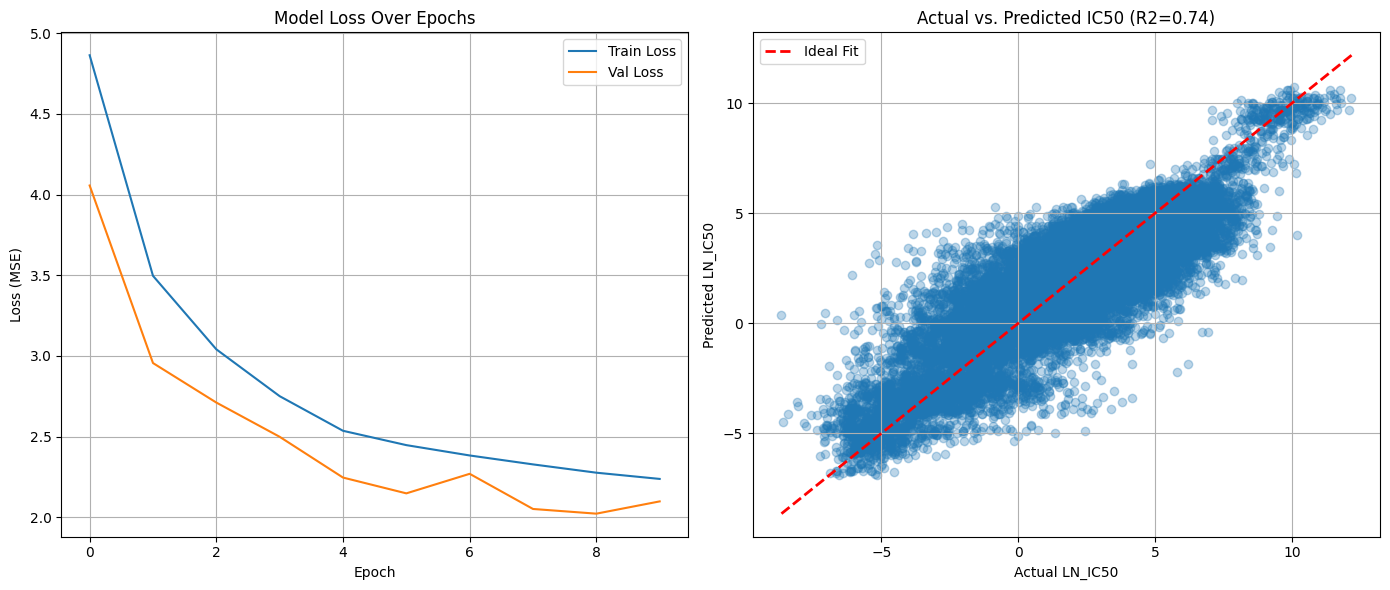

2025-12-14 17:01:51,979 - INFO - Script finished successfully.


In [9]:
logger.info("Plotting results...")
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, label='Ideal Fit')
plt.title(f'Actual vs. Predicted IC50 (R2={r2:.2f})')
plt.xlabel('Actual LN_IC50')
plt.ylabel('Predicted LN_IC50')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

logger.info("Script finished successfully.")